# Computer Vision Nanodegree

## Project: Image Captioning

---

In this notebook, you will train your CNN-RNN model.  

You are welcome and encouraged to try out many different architectures and hyperparameters when searching for a good model.

This does have the potential to make the project quite messy!  Before submitting your project, make sure that you clean up:
- the code you write in this notebook.  The notebook should describe how to train a single CNN-RNN architecture, corresponding to your final choice of hyperparameters.  You should structure the notebook so that the reviewer can replicate your results by running the code in this notebook.  
- the output of the code cell in **Step 2**.  The output should show the output obtained when training the model from scratch.

This notebook **will be graded**.  

Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Training Setup
- [Step 2](#step2): Train your Model
- [Step 3](#step3): (Optional) Validate your Model

<a id='step1'></a>
## Step 1: Training Setup

In this step of the notebook, you will customize the training of your CNN-RNN model by specifying hyperparameters and setting other options that are important to the training procedure.  The values you set now will be used when training your model in **Step 2** below.

You should only amend blocks of code that are preceded by a `TODO` statement.  **Any code blocks that are not preceded by a `TODO` statement should not be modified**.

### Task #1

Begin by setting the following variables:
- `batch_size` - the batch size of each training batch.  It is the number of image-caption pairs used to amend the model weights in each training step. 
- `vocab_threshold` - the minimum word count threshold.  Note that a larger threshold will result in a smaller vocabulary, whereas a smaller threshold will include rarer words and result in a larger vocabulary.  
- `vocab_from_file` - a Boolean that decides whether to load the vocabulary from file. 
- `embed_size` - the dimensionality of the image and word embeddings.  
- `hidden_size` - the number of features in the hidden state of the RNN decoder.  
- `num_epochs` - the number of epochs to train the model.  We recommend that you set `num_epochs=3`, but feel free to increase or decrease this number as you wish.  [This paper](https://arxiv.org/pdf/1502.03044.pdf) trained a captioning model on a single state-of-the-art GPU for 3 days, but you'll soon see that you can get reasonable results in a matter of a few hours!  (_But of course, if you want your model to compete with current research, you will have to train for much longer._)
- `save_every` - determines how often to save the model weights.  We recommend that you set `save_every=1`, to save the model weights after each epoch.  This way, after the `i`th epoch, the encoder and decoder weights will be saved in the `models/` folder as `encoder-i.pkl` and `decoder-i.pkl`, respectively.
- `print_every` - determines how often to print the batch loss to the Jupyter notebook while training.  Note that you **will not** observe a monotonic decrease in the loss function while training - this is perfectly fine and completely expected!  You are encouraged to keep this at its default value of `100` to avoid clogging the notebook, but feel free to change it.
- `log_file` - the name of the text file containing - for every step - how the loss and perplexity evolved during training.

If you're not sure where to begin to set some of the values above, you can peruse [this paper](https://arxiv.org/pdf/1502.03044.pdf) and [this paper](https://arxiv.org/pdf/1411.4555.pdf) for useful guidance!  **To avoid spending too long on this notebook**, you are encouraged to consult these suggested research papers to obtain a strong initial guess for which hyperparameters are likely to work best.  Then, train a single model, and proceed to the next notebook (**3_Inference.ipynb**).  If you are unhappy with your performance, you can return to this notebook to tweak the hyperparameters (and/or the architecture in **model.py**) and re-train your model.

### Question 1

**Question:** Describe your CNN-RNN architecture in detail.  With this architecture in mind, how did you select the values of the variables in Task 1?  If you consulted a research paper detailing a successful implementation of an image captioning model, please provide the reference.

**Answer:** 

During the implementation of this project, I relied on the proposed paper: https://arxiv.org/pdf/1411.4555.pdf . This helped me to define CNN-RNN architecture. The mpdel consists of 2 parts: Encoder - CNN and Decoder - RNN. 
1. Encoder gets features of the image with ResNet50 (Riched state of the art performance on ImageNet dataset in 2015 + there is an pytorch Api for this model with pretrained weights) The result of ResNet is going to fully connected layer which converts image features to embbeding space. 
2. The decoder part of the model consists of Embedding layer,  LSTM layers and fully connected layer which has size of vocabulary and gives word's scores. The word with maximum score is the word we choose to get next word. 

To determine with values of vocabulary_threshold, embed_size, hidden_size I consulted with the pepper I mentioned but I reduced the embeding size to lighten the model. I were modifying  the batch size folowing the folowing logic: the biger lr the smaler batch size. 


### (Optional) Task #2

Note that we have provided a recommended image transform `transform_train` for pre-processing the training images, but you are welcome (and encouraged!) to modify it as you wish.  When modifying this transform, keep in mind that:
- the images in the dataset have varying heights and widths, and 
- if using a pre-trained model, you must perform the corresponding appropriate normalization.

### Question 2

**Question:** How did you select the transform in `transform_train`?  If you left the transform at its provided value, why do you think that it is a good choice for your CNN architecture?

**Answer:** I didn't modified the transform function because I used the pretrained resnet in Encoder part. Pretrained models conected to image transform so they can have worse performance if an image transform is differ from the transform the model were trained. 

### Task #3

Next, you will specify a Python list containing the learnable parameters of the model.  For instance, if you decide to make all weights in the decoder trainable, but only want to train the weights in the embedding layer of the encoder, then you should set `params` to something like:
```
params = list(decoder.parameters()) + list(encoder.embed.parameters()) 
```

### Question 3

**Question:** How did you select the trainable parameters of your architecture?  Why do you think this is a good choice?

**Answer:** I've decided to keep pretrained resnet parametrs unmodifed not to overfit my model + this speeds up learning process a bit.

### Task #4

Finally, you will select an [optimizer](http://pytorch.org/docs/master/optim.html#torch.optim.Optimizer).

### Question 4

**Question:** How did you select the optimizer used to train your model?

**Answer:** The Adam optimizer is considered one of the best optimizsrs nowdays. It takes less memory than other optimizers and faster converge

In [3]:
%reload_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torchvision import transforms
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from data_loader_val import CoCoValDataset
from model import EncoderCNN, DecoderRNN
import math
from dataclasses import dataclass



## TODO #1: Select appropriate values for the Python variables below.
@dataclass(init=True)
class Params:
    batch_size: int = 32          # batch size
    vocab_threshold: int = 5        # minimum word count threshold
    vocab_from_file: bool = True    # if True, load existing vocab file
    embed_size: int = 256           # dimensionality of image and word embeddings
    hidden_size: int = 512      # number of features in hidden state of the RNN decoder
    num_layers: int = 1
    num_epochs: int = 3             # number of training epochs
    save_every: int = 1             # determines frequency of saving model weights
    print_every: int = 100          # determines window for printing average loss
    log_file: str = 'training_log_1.txt'       # name of file with saved training loss and perplexity
    lr: float = 0.001
    model_exten: str = "1"

<a id='step2'></a>
## Step 2: Train your Model

Once you have executed the code cell in **Step 1**, the training procedure below should run without issue.  

It is completely fine to leave the code cell below as-is without modifications to train your model.  However, if you would like to modify the code used to train the model below, you must ensure that your changes are easily parsed by your reviewer.  In other words, make sure to provide appropriate comments to describe how your code works!  

You may find it useful to load saved weights to resume training.  In that case, note the names of the files containing the encoder and decoder weights that you'd like to load (`encoder_file` and `decoder_file`).  Then you can load the weights by using the lines below:

```python
# Load pre-trained weights before resuming training.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))
```

While trying out parameters, make sure to take extensive notes and record the settings that you used in your various training runs.  In particular, you don't want to encounter a situation where you've trained a model for several hours but can't remember what settings you used :).

### A Note on Tuning Hyperparameters

To figure out how well your model is doing, you can look at how the training loss and perplexity evolve during training - and for the purposes of this project, you are encouraged to amend the hyperparameters based on this information.  

However, this will not tell you if your model is overfitting to the training data, and, unfortunately, overfitting is a problem that is commonly encountered when training image captioning models.  

For this project, you need not worry about overfitting. **This project does not have strict requirements regarding the performance of your model**, and you just need to demonstrate that your model has learned **_something_** when you generate captions on the test data.  For now, we strongly encourage you to train your model for the suggested 3 epochs without worrying about performance; then, you should immediately transition to the next notebook in the sequence (**3_Inference.ipynb**) to see how your model performs on the test data.  If your model needs to be changed, you can come back to this notebook, amend hyperparameters (if necessary), and re-train the model.

That said, if you would like to go above and beyond in this project, you can read about some approaches to minimizing overfitting in section 4.3.1 of [this paper](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7505636).  In the next (optional) step of this notebook, we provide some guidance for assessing the performance on the validation dataset.

In [6]:
import torch.utils.data as data
import numpy as np
import os
from torch.utils.tensorboard import SummaryWriter
import requests
import time

def training(train_params):

    # (Optional) TODO #2: Amend the image transform below.
    transform_train = transforms.Compose([ 
        transforms.Resize(256),                          # smaller edge of image resized to 256
        transforms.RandomCrop(224),                      # get 224x224 crop from random location
        transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
        transforms.ToTensor(),                           # convert the PIL Image to a tensor
        transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                            (0.229, 0.224, 0.225))])

    # Build data loader.
    data_loader = get_loader(transform=transform_train,
                            mode='train',
                            batch_size=train_params.batch_size,
                            vocab_threshold=train_params.vocab_threshold,
                            vocab_from_file=train_params.vocab_from_file)

    # The size of the vocabulary.
    vocab_size = len(data_loader.dataset.vocab)

    # Initialize the encoder and decoder. 
    encoder = EncoderCNN(train_params.embed_size)
    decoder = DecoderRNN(train_params.embed_size, train_params.hidden_size, vocab_size, train_params.num_layers)

    # Move models to GPU if CUDA is available. 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    encoder.to(device)
    decoder.to(device)

    # Define the loss function. 
    criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

    # TODO #3: Specify the learnable parameters of the model.
    params = list(decoder.parameters()) + list(encoder.embed.parameters())

    # TODO #4: Define the optimizer.
    optimizer = torch.optim.Adam(params, lr= train_params.lr)

    # Set the total number of training steps per epoch.
    total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)
    f = open(train_params.log_file, 'w')

    writer = SummaryWriter()
    n_iter = 1

    for epoch in range(1, train_params.num_epochs+1):
        
        for i_step in range(1, total_step+1):
            
            
            # Randomly sample a caption length, and sample indices with that length.
            indices = data_loader.dataset.get_train_indices()
            # Create and assign a batch sampler to retrieve a batch with the sampled indices.
            new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
            data_loader.batch_sampler.sampler = new_sampler
            
            # Obtain the batch.
            images, captions = next(iter(data_loader))

            # Move batch of images and captions to GPU if CUDA is available.
            images = images.to(device)
            captions = captions.to(device)
            
            # Zero the gradients.
            decoder.zero_grad()
            encoder.zero_grad()
            
            # Pass the inputs through the CNN-RNN model.
            features = encoder(images)
            outputs = decoder(features, captions)
            
            # Calculate the batch loss.
            loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
            
            
            # Backward pass.
            loss.backward()
            
            # Update the parameters in the optimizer.
            optimizer.step()
                
            # Get training statistics.
            stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, train_params.num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))

            # Print training statistics (on same line).
            print('\r' + stats, end="")
            sys.stdout.flush()
            
            # Print training statistics to file.
            f.write(stats + '\n')
            f.flush()
            
            # Print training statistics (on different line).
            if (i_step - 1) % train_params.print_every == 0:
                writer.add_scalar(f'Params_{train_params.model_exten}/Loss/train', loss.item(), n_iter)
                writer.add_scalar(f'Params_{train_params.model_exten}/Perplexity/train', np.exp(loss.item()), n_iter)
                n_iter +=1
                print('\r' + stats)
                
        # Save the weights.
        if epoch % train_params.save_every == 0:
            torch.save(decoder.state_dict(), os.path.join('./models', f'decoder_{train_params.model_exten}-{epoch}.pkl'))
            torch.save(encoder.state_dict(), os.path.join('./models', f'encoder_{train_params.model_exten}-{epoch}.pkl'))

    # Close the training log file.
    f.close()
    return 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def clean_sentence(output, dataset):
    sentence = ''
    for i in range(len(output)-1):
        w = output[i]
        sentence += dataset.vocab.idx2word[w] + " "
    
    w = output[-1]
    sentence += dataset.vocab.idx2word[w]
    return sentence

def load_params_into_model(params, vocab_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    encoder_file = f'encoder_{params.model_exten}-{params.num_epochs}.pkl' 
    decoder_file = f'decoder_{params.model_exten}-{params.num_epochs}.pkl'


    # Initialize the encoder and decoder, and set each to inference mode.
    encoder = EncoderCNN(params.embed_size)
    encoder.eval()
    decoder = DecoderRNN(params.embed_size, params.hidden_size, vocab_size, num_layers=params.num_layers)
    decoder.eval()

    # Load the trained weights.
    encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
    decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

    # Move models to GPU if CUDA is available.
    encoder.to(device)
    decoder.to(device)
    return encoder, decoder

def get_prediction(encoder, decoder, val_dataset, img_ind):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    orig_image, image, captions, data_ind = val_dataset.__getitem__(img_ind)
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image.unsqueeze(0)).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output, val_dataset)
    print("prediction: ", sentence)
    print("caption: ", captions)

In [9]:
params1 = Params()

params2 = Params()
params2.num_layers = 2
params2.num_epochs = 6
params2.log_file = 'training_log_2.txt'
params2.model_exten = "2"

params3 = Params()
params3.lr = 0.01
params3.num_layers = 2
params3.num_epochs = 6
params3.log_file = 'training_log_3.txt'
params3.model_exten = "3"

params4 = Params()
params4.batch_size = 64
params4.lr = 0.0005
params4.num_layers = 2
params4.num_epochs = 6
params4.log_file = 'training_log_4.txt'
params4.model_exten = "4"

params5 = Params()
params5.batch_size = 64
params5.lr = 0.0005
params5.num_layers = 1
params5.num_epochs = 6
params5.log_file = 'training_log_5.txt'
params5.model_exten = "5"

params6 = Params()
params6.embed_size = 512
params6.batch_size = 64
params6.lr = 0.001
params6.num_layers = 1
params6.num_epochs = 6
params6.log_file = 'training_log_6.txt'
params6.model_exten = "6"

In [31]:
train_loss = training(params1)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:17<00:00, 24032.77it/s]


Epoch [1/3], Step [1/12942], Loss: 9.0884, Perplexity: 8851.7150
Epoch [1/3], Step [101/12942], Loss: 4.1850, Perplexity: 65.6928
Epoch [1/3], Step [201/12942], Loss: 3.7888, Perplexity: 44.20522
Epoch [1/3], Step [301/12942], Loss: 3.4789, Perplexity: 32.4249
Epoch [1/3], Step [401/12942], Loss: 3.4041, Perplexity: 30.0875
Epoch [1/3], Step [501/12942], Loss: 4.1629, Perplexity: 64.2589
Epoch [1/3], Step [601/12942], Loss: 3.2587, Perplexity: 26.0167
Epoch [1/3], Step [701/12942], Loss: 3.3261, Perplexity: 27.8303
Epoch [1/3], Step [801/12942], Loss: 3.2627, Perplexity: 26.1206
Epoch [1/3], Step [901/12942], Loss: 2.8132, Perplexity: 16.6639
Epoch [1/3], Step [1001/12942], Loss: 2.9219, Perplexity: 18.5761
Epoch [1/3], Step [1101/12942], Loss: 3.0645, Perplexity: 21.4242
Epoch [1/3], Step [1201/12942], Loss: 2.6814, Perplexity: 14.6059
Epoch [1/3], Step [1301/12942], Loss: 2.7590, Perplexity: 15.7842
Epoch [1/3], Step [1401/12942], Loss: 3.4691, Perplexity: 32.1088
Epoch [1/3], Step [

In [48]:
transform_val = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                        (0.229, 0.224, 0.225))])

# Create the data loader.

img_folder = '/opt/cocoapi/images/val2014/'
annotations_file = '/opt/cocoapi/annotations/captions_val2014.json'
mode='val'

val_dataset = CoCoValDataset(transform=transform_val,
                        mode=mode,
                        batch_size=1,
                        vocab_threshold=params1.vocab_threshold,
                        vocab_file='./vocab.pkl',
                        start_word="<start>",
                        end_word="<end>",
                        unk_word="<unk>",
                        annotations_file=annotations_file,
                        vocab_from_file=True,
                        img_folder=img_folder)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


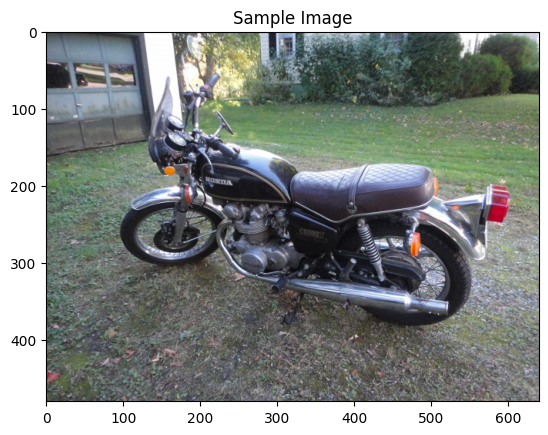

prediction:  a motorcycle parked on the side of a road .
caption:  ['A black Honda motorcycle parked in front of a garage.', 'A Honda motorcycle parked in a grass driveway', 'A black Honda motorcycle with a dark burgundy seat.', 'Ma motorcycle parked on the gravel in front of a garage', 'A motorcycle with its brake extended standing outside']


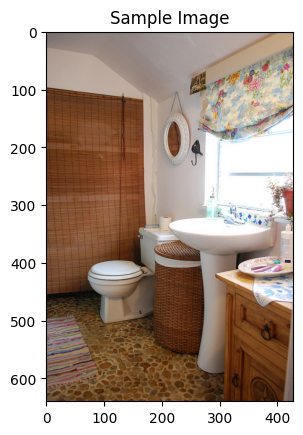

prediction:  a bathroom with a toilet , sink and bathtub .
caption:  ['A bathroom with a toilet, sink, and shower.', 'A full bathroom with a wicker laundry basket.', 'A little bathrood decorated with many colorful objects', 'A small bathroom containing a toilet and sink. ', 'Bathroom containing a toilet, a sink and a wicker basket.']


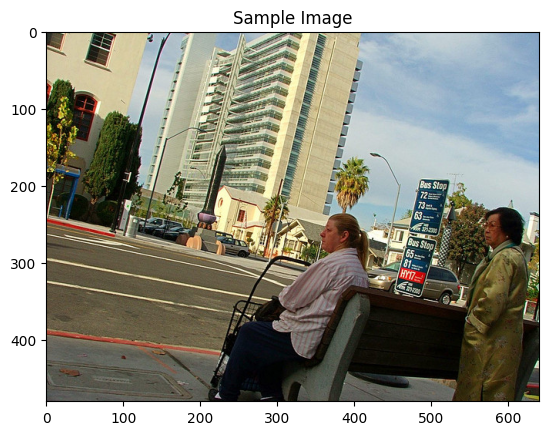

prediction:  a busy city street with a large number of people walking
caption:  ['Two women waiting at a bench next to a street.', 'A woman sitting on a bench and a woman standing waiting for the bus.', 'A woman sitting on a bench in the middle of the city', 'A woman sitting on a bench and a woman standing behind the bench at a bus stop', 'A woman and another woman waiting at a stop.']


In [68]:
encoder, decoder = load_params_into_model(params1, len(val_dataset.vocab))
get_prediction(encoder, decoder, val_dataset, 1)
get_prediction(encoder, decoder, val_dataset, 5)
get_prediction(encoder, decoder, val_dataset, 10)

In [39]:
train_loss = training(params2)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:16<00:00, 24385.65it/s]


Epoch [1/6], Step [1/12942], Loss: 9.0785, Perplexity: 8764.7821
Epoch [1/6], Step [101/12942], Loss: 4.7669, Perplexity: 117.5508
Epoch [1/6], Step [201/12942], Loss: 3.9905, Perplexity: 54.08323
Epoch [1/6], Step [301/12942], Loss: 3.8894, Perplexity: 48.88253
Epoch [1/6], Step [401/12942], Loss: 3.6204, Perplexity: 37.3518
Epoch [1/6], Step [501/12942], Loss: 3.8275, Perplexity: 45.94641
Epoch [1/6], Step [601/12942], Loss: 3.1653, Perplexity: 23.6950
Epoch [1/6], Step [701/12942], Loss: 3.4131, Perplexity: 30.3600
Epoch [1/6], Step [801/12942], Loss: 3.5140, Perplexity: 33.5817
Epoch [1/6], Step [901/12942], Loss: 3.4709, Perplexity: 32.1653
Epoch [1/6], Step [1001/12942], Loss: 3.2496, Perplexity: 25.7800
Epoch [1/6], Step [1101/12942], Loss: 3.2513, Perplexity: 25.8244
Epoch [1/6], Step [1201/12942], Loss: 3.1149, Perplexity: 22.5323
Epoch [1/6], Step [1301/12942], Loss: 3.1837, Perplexity: 24.1368
Epoch [1/6], Step [1401/12942], Loss: 3.0960, Perplexity: 22.1103
Epoch [1/6], Ste

/home/ekaterina/anaconda3/envs/uds/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


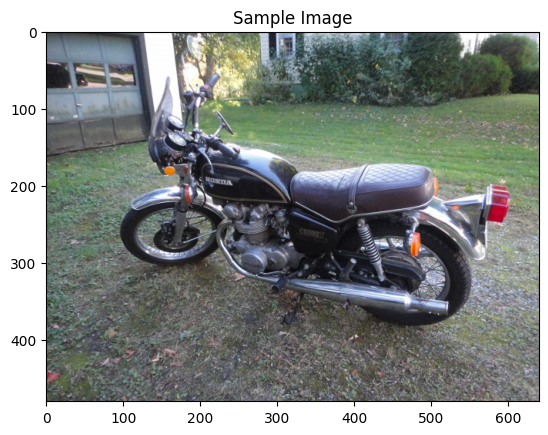

prediction:  a motorcycle parked on the grass near a tree .
caption:  ['A black Honda motorcycle parked in front of a garage.', 'A Honda motorcycle parked in a grass driveway', 'A black Honda motorcycle with a dark burgundy seat.', 'Ma motorcycle parked on the gravel in front of a garage', 'A motorcycle with its brake extended standing outside']


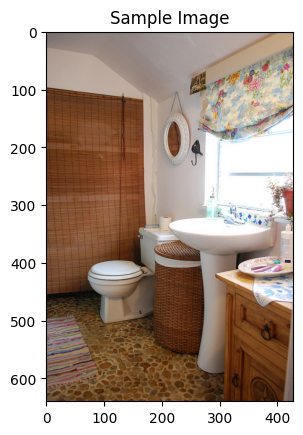

prediction:  a bathroom with a toilet and a sink
caption:  ['A bathroom with a toilet, sink, and shower.', 'A full bathroom with a wicker laundry basket.', 'A little bathrood decorated with many colorful objects', 'A small bathroom containing a toilet and sink. ', 'Bathroom containing a toilet, a sink and a wicker basket.']


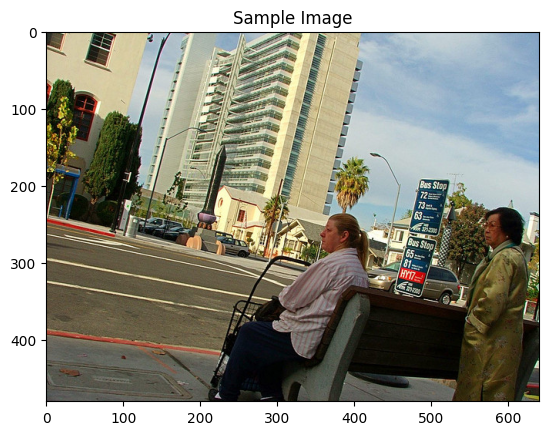

prediction:  a group of people walking down a street next to a building .
caption:  ['Two women waiting at a bench next to a street.', 'A woman sitting on a bench and a woman standing waiting for the bus.', 'A woman sitting on a bench in the middle of the city', 'A woman sitting on a bench and a woman standing behind the bench at a bus stop', 'A woman and another woman waiting at a stop.']


In [67]:
encoder, decoder = load_params_into_model(params2, len(val_dataset.vocab))
get_prediction(encoder, decoder, val_dataset, 1)
get_prediction(encoder, decoder, val_dataset, 5)
get_prediction(encoder, decoder, val_dataset, 10)

In [70]:
train_loss = training(params3)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.31s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:17<00:00, 23737.18it/s]
/home/ekaterina/anaconda3/envs/uds/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/6], Step [1/12942], Loss: 9.0815, Perplexity: 8791.0595
Epoch [1/6], Step [101/12942], Loss: 4.5320, Perplexity: 92.9475
Epoch [1/6], Step [201/12942], Loss: 3.7080, Perplexity: 40.77227
Epoch [1/6], Step [301/12942], Loss: 3.9381, Perplexity: 51.3214
Epoch [1/6], Step [401/12942], Loss: 4.1461, Perplexity: 63.18854
Epoch [1/6], Step [501/12942], Loss: 3.7873, Perplexity: 44.13774
Epoch [1/6], Step [601/12942], Loss: 3.2763, Perplexity: 26.4780
Epoch [1/6], Step [701/12942], Loss: 3.0370, Perplexity: 20.8435
Epoch [1/6], Step [801/12942], Loss: 3.3217, Perplexity: 27.7082
Epoch [1/6], Step [901/12942], Loss: 3.3700, Perplexity: 29.0788
Epoch [1/6], Step [1001/12942], Loss: 3.2310, Perplexity: 25.3046
Epoch [1/6], Step [1101/12942], Loss: 3.0199, Perplexity: 20.4896
Epoch [1/6], Step [1201/12942], Loss: 3.0944, Perplexity: 22.0751
Epoch [1/6], Step [1301/12942], Loss: 3.1653, Perplexity: 23.6957
Epoch [1/6], Step [1401/12942], Loss: 3.4680, Perplexity: 32.07268
Epoch [1/6], Ste

/home/ekaterina/anaconda3/envs/uds/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


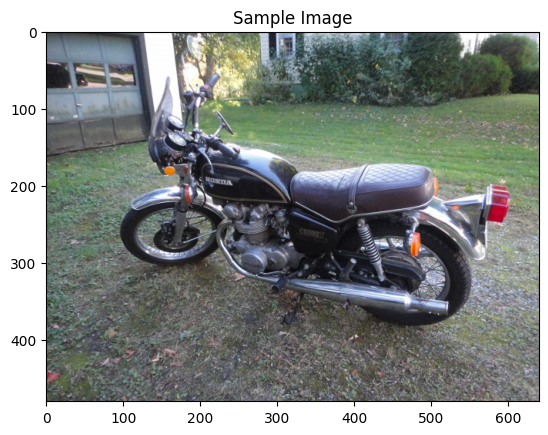

prediction:  a man in a suit and tie and a hat .
caption:  ['A black Honda motorcycle parked in front of a garage.', 'A Honda motorcycle parked in a grass driveway', 'A black Honda motorcycle with a dark burgundy seat.', 'Ma motorcycle parked on the gravel in front of a garage', 'A motorcycle with its brake extended standing outside']


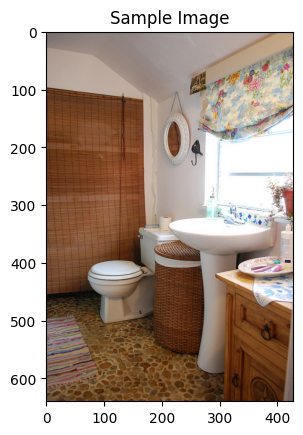

prediction:  a man in a suit and tie and a hat .
caption:  ['A bathroom with a toilet, sink, and shower.', 'A full bathroom with a wicker laundry basket.', 'A little bathrood decorated with many colorful objects', 'A small bathroom containing a toilet and sink. ', 'Bathroom containing a toilet, a sink and a wicker basket.']


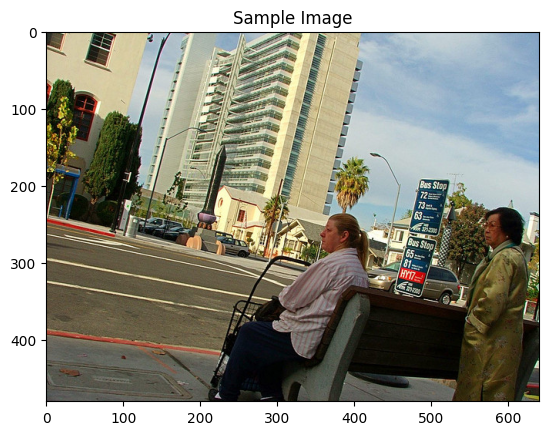

prediction:  a man in a suit and tie and a hat .
caption:  ['Two women waiting at a bench next to a street.', 'A woman sitting on a bench and a woman standing waiting for the bus.', 'A woman sitting on a bench in the middle of the city', 'A woman sitting on a bench and a woman standing behind the bench at a bus stop', 'A woman and another woman waiting at a stop.']


In [71]:
encoder, decoder = load_params_into_model(params3, len(val_dataset.vocab))
get_prediction(encoder, decoder, val_dataset, 1)
get_prediction(encoder, decoder, val_dataset, 5)
get_prediction(encoder, decoder, val_dataset, 10)

In [72]:
train_loss = training(params4)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.28s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:17<00:00, 24333.65it/s]
/home/ekaterina/anaconda3/envs/uds/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/6], Step [1/6471], Loss: 9.0841, Perplexity: 8813.9435
Epoch [1/6], Step [101/6471], Loss: 4.5261, Perplexity: 92.39872
Epoch [1/6], Step [201/6471], Loss: 4.0688, Perplexity: 58.48785
Epoch [1/6], Step [301/6471], Loss: 3.7102, Perplexity: 40.86143
Epoch [1/6], Step [401/6471], Loss: 4.4112, Perplexity: 82.3717
Epoch [1/6], Step [501/6471], Loss: 3.8922, Perplexity: 49.01914
Epoch [1/6], Step [601/6471], Loss: 4.0874, Perplexity: 59.58514
Epoch [1/6], Step [701/6471], Loss: 3.5465, Perplexity: 34.6904
Epoch [1/6], Step [801/6471], Loss: 3.1983, Perplexity: 24.4901
Epoch [1/6], Step [901/6471], Loss: 3.3322, Perplexity: 27.99946
Epoch [1/6], Step [1001/6471], Loss: 3.1748, Perplexity: 23.9217
Epoch [1/6], Step [1101/6471], Loss: 3.2768, Perplexity: 26.4904
Epoch [1/6], Step [1201/6471], Loss: 3.4504, Perplexity: 31.51410
Epoch [1/6], Step [1301/6471], Loss: 3.0609, Perplexity: 21.3473
Epoch [1/6], Step [1401/6471], Loss: 2.8203, Perplexity: 16.7823
Epoch [1/6], Step [1501/6471

/home/ekaterina/anaconda3/envs/uds/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


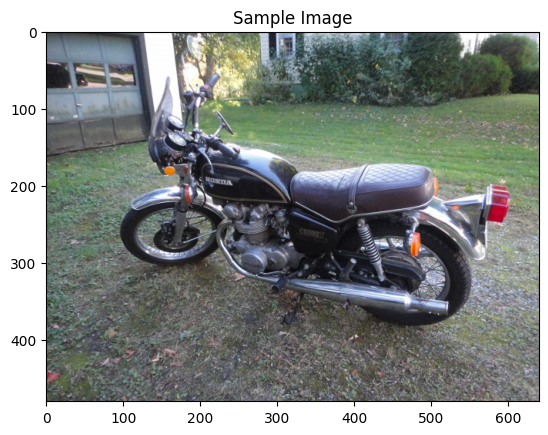

prediction:  a motorcycle parked in a parking lot next to a tree .
caption:  ['A black Honda motorcycle parked in front of a garage.', 'A Honda motorcycle parked in a grass driveway', 'A black Honda motorcycle with a dark burgundy seat.', 'Ma motorcycle parked on the gravel in front of a garage', 'A motorcycle with its brake extended standing outside']


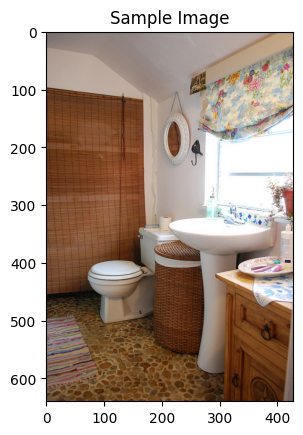

prediction:  a bathroom with a toilet and a sink .
caption:  ['A bathroom with a toilet, sink, and shower.', 'A full bathroom with a wicker laundry basket.', 'A little bathrood decorated with many colorful objects', 'A small bathroom containing a toilet and sink. ', 'Bathroom containing a toilet, a sink and a wicker basket.']


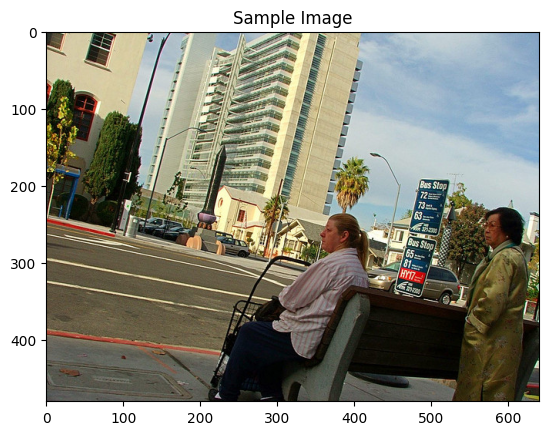

prediction:  a man sitting on a bench next to a woman .
caption:  ['Two women waiting at a bench next to a street.', 'A woman sitting on a bench and a woman standing waiting for the bus.', 'A woman sitting on a bench in the middle of the city', 'A woman sitting on a bench and a woman standing behind the bench at a bus stop', 'A woman and another woman waiting at a stop.']


In [75]:
encoder, decoder = load_params_into_model(params4, len(val_dataset.vocab))
get_prediction(encoder, decoder, val_dataset, 1)
get_prediction(encoder, decoder, val_dataset, 5)
get_prediction(encoder, decoder, val_dataset, 10)

In [73]:
train_loss = training(params5)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:17<00:00, 23970.39it/s]


Epoch [1/6], Step [1/6471], Loss: 9.0849, Perplexity: 8821.4193
Epoch [1/6], Step [101/6471], Loss: 4.3148, Perplexity: 74.79946
Epoch [1/6], Step [201/6471], Loss: 3.6424, Perplexity: 38.18359
Epoch [1/6], Step [301/6471], Loss: 3.7303, Perplexity: 41.6918
Epoch [1/6], Step [401/6471], Loss: 3.3237, Perplexity: 27.7622
Epoch [1/6], Step [501/6471], Loss: 3.5585, Perplexity: 35.1094
Epoch [1/6], Step [601/6471], Loss: 3.3026, Perplexity: 27.18376
Epoch [1/6], Step [701/6471], Loss: 3.3566, Perplexity: 28.6921
Epoch [1/6], Step [801/6471], Loss: 3.0853, Perplexity: 21.8731
Epoch [1/6], Step [901/6471], Loss: 3.2805, Perplexity: 26.58823
Epoch [1/6], Step [1001/6471], Loss: 3.0305, Perplexity: 20.7080
Epoch [1/6], Step [1101/6471], Loss: 3.3876, Perplexity: 29.5940
Epoch [1/6], Step [1201/6471], Loss: 2.9014, Perplexity: 18.1999
Epoch [1/6], Step [1301/6471], Loss: 2.8158, Perplexity: 16.7058
Epoch [1/6], Step [1401/6471], Loss: 3.0994, Perplexity: 22.18385
Epoch [1/6], Step [1501/6471],

/home/ekaterina/anaconda3/envs/uds/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


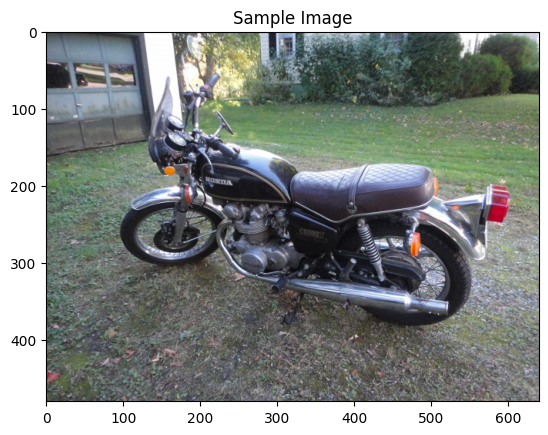

prediction:  a motorcycle is parked on the side of a road .
caption:  ['A black Honda motorcycle parked in front of a garage.', 'A Honda motorcycle parked in a grass driveway', 'A black Honda motorcycle with a dark burgundy seat.', 'Ma motorcycle parked on the gravel in front of a garage', 'A motorcycle with its brake extended standing outside']


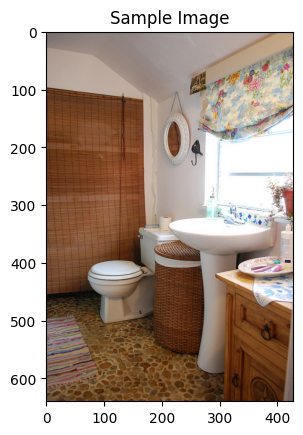

prediction:  a bathroom with a toilet , sink , and bathtub .
caption:  ['A bathroom with a toilet, sink, and shower.', 'A full bathroom with a wicker laundry basket.', 'A little bathrood decorated with many colorful objects', 'A small bathroom containing a toilet and sink. ', 'Bathroom containing a toilet, a sink and a wicker basket.']


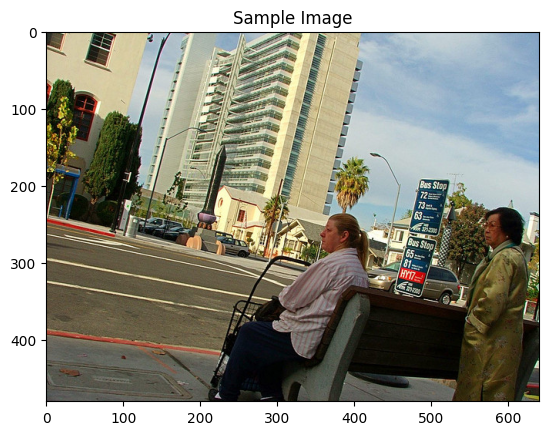

prediction:  a man is sitting on a bench reading a book .
caption:  ['Two women waiting at a bench next to a street.', 'A woman sitting on a bench and a woman standing waiting for the bus.', 'A woman sitting on a bench in the middle of the city', 'A woman sitting on a bench and a woman standing behind the bench at a bus stop', 'A woman and another woman waiting at a stop.']


In [76]:
encoder, decoder = load_params_into_model(params5, len(val_dataset.vocab))
get_prediction(encoder, decoder, val_dataset, 1)
get_prediction(encoder, decoder, val_dataset, 5)
get_prediction(encoder, decoder, val_dataset, 10)

In [74]:
train_loss = training(params6)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:17<00:00, 24254.98it/s]


Epoch [1/6], Step [1/6471], Loss: 9.1002, Perplexity: 8956.7310
Epoch [1/6], Step [101/6471], Loss: 3.7743, Perplexity: 43.5676
Epoch [1/6], Step [201/6471], Loss: 3.3934, Perplexity: 29.7656
Epoch [1/6], Step [301/6471], Loss: 3.2853, Perplexity: 26.7175
Epoch [1/6], Step [401/6471], Loss: 3.3101, Perplexity: 27.3876
Epoch [1/6], Step [501/6471], Loss: 3.1974, Perplexity: 24.4693
Epoch [1/6], Step [601/6471], Loss: 2.9642, Perplexity: 19.3795
Epoch [1/6], Step [701/6471], Loss: 2.9447, Perplexity: 19.0043
Epoch [1/6], Step [801/6471], Loss: 2.9556, Perplexity: 19.2137
Epoch [1/6], Step [901/6471], Loss: 2.7349, Perplexity: 15.4082
Epoch [1/6], Step [1001/6471], Loss: 2.8045, Perplexity: 16.5181
Epoch [1/6], Step [1101/6471], Loss: 2.7301, Perplexity: 15.3337
Epoch [1/6], Step [1201/6471], Loss: 2.7767, Perplexity: 16.0657
Epoch [1/6], Step [1301/6471], Loss: 2.7002, Perplexity: 14.8830
Epoch [1/6], Step [1401/6471], Loss: 2.8784, Perplexity: 17.7857
Epoch [1/6], Step [1501/6471], Loss

/home/ekaterina/anaconda3/envs/uds/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


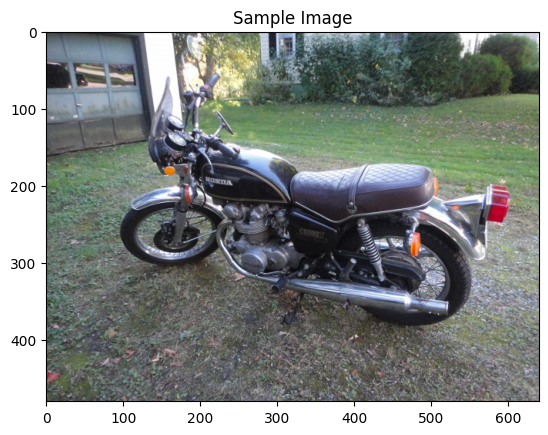

prediction:  a motorcycle parked on the side of a road .
caption:  ['A black Honda motorcycle parked in front of a garage.', 'A Honda motorcycle parked in a grass driveway', 'A black Honda motorcycle with a dark burgundy seat.', 'Ma motorcycle parked on the gravel in front of a garage', 'A motorcycle with its brake extended standing outside']


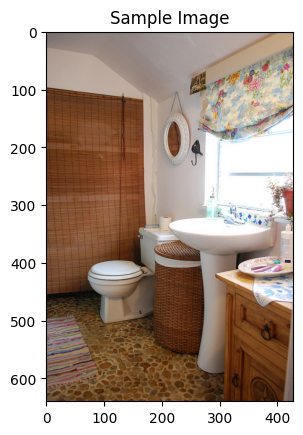

prediction:  a bathroom with a toilet , sink , and shower .
caption:  ['A bathroom with a toilet, sink, and shower.', 'A full bathroom with a wicker laundry basket.', 'A little bathrood decorated with many colorful objects', 'A small bathroom containing a toilet and sink. ', 'Bathroom containing a toilet, a sink and a wicker basket.']


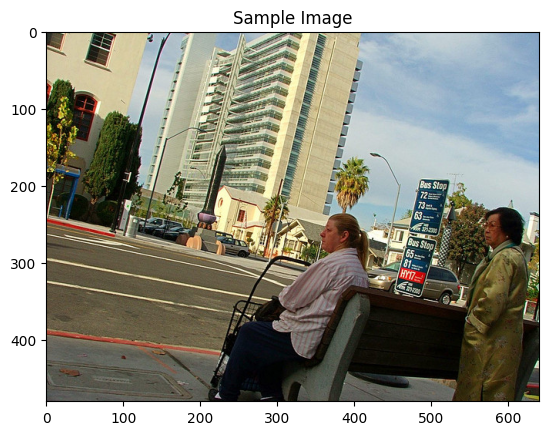

prediction:  a man is standing in front of a building .
caption:  ['Two women waiting at a bench next to a street.', 'A woman sitting on a bench and a woman standing waiting for the bus.', 'A woman sitting on a bench in the middle of the city', 'A woman sitting on a bench and a woman standing behind the bench at a bus stop', 'A woman and another woman waiting at a stop.']


In [77]:
encoder, decoder = load_params_into_model(params6, len(val_dataset.vocab))
get_prediction(encoder, decoder, val_dataset, 1)
get_prediction(encoder, decoder, val_dataset, 5)
get_prediction(encoder, decoder, val_dataset, 10)

### Let's look at loss and perplexity grafics for each set of parametrs.

<img src="loss_params1_3.png"> <img src="loss_params4_6.png"> 

We can see that the model with the third set of parametrs has high perplexity, and the loss function doesn't decrease. It means that the model didn't learn. If we compare ther model, the smallest loss we have with 5th set of parametrs. Let's see what show metrics, which evaluste quality of cations, on validation dataset

<a id='step3'></a>
## Step 3: (Optional) Validate your Model

To assess potential overfitting, one approach is to assess performance on a validation set.  If you decide to do this **optional** task, you are required to first complete all of the steps in the next notebook in the sequence (**3_Inference.ipynb**); as part of that notebook, you will write and test code (specifically, the `sample` method in the `DecoderRNN` class) that uses your RNN decoder to generate captions.  That code will prove incredibly useful here. 

If you decide to validate your model, please do not edit the data loader in **data_loader.py**.  Instead, create a new file named **data_loader_val.py** containing the code for obtaining the data loader for the validation data.  You can access:
- the validation images at filepath `'/opt/cocoapi/images/train2014/'`, and
- the validation image caption annotation file at filepath `'/opt/cocoapi/annotations/captions_val2014.json'`.

The suggested approach to validating your model involves creating a json file such as [this one](https://github.com/cocodataset/cocoapi/blob/master/results/captions_val2014_fakecap_results.json) containing your model's predicted captions for the validation images.  Then, you can write your own script or use one that you [find online](https://github.com/tylin/coco-caption) to calculate the BLEU score of your model.  You can read more about the BLEU score, along with other evaluation metrics (such as TEOR and Cider) in section 4.1 of [this paper](https://arxiv.org/pdf/1411.4555.pdf).  For more information about how to use the annotation file, check out the [website](http://cocodataset.org/#download) for the COCO dataset.

## VALIDATION

To validate models I used open-source library - https://github.com/tylin/coco-caption and calculated such metrics as Blue, Rouge_L, Meteor and Cider. Blue score evaluate  precision of predicted captions, meteor and Rouge_L combine precision and recall, and Cider metric gives higher score to predicted caption that are similar to multiple referent captions, showing whether the model managed to catch the overall idea of the image.

In [10]:
# Watch for any changes in model.py, and re-load it automatically.
%reload_ext autoreload
%autoreload 2

from data_loader_val import CoCoValDataset
import os

import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
sys.path.append('/opt/coco-caption-master')
from pycocoevalcap.eval import COCOEvalCap

In [11]:
# (Optional) TODO: Validate your model.

def get_validation_set_captions(params):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    transform_val = transforms.Compose([ 
        transforms.Resize(256),                          # smaller edge of image resized to 256
        transforms.RandomCrop(224),                      # get 224x224 crop from random location
        transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
        transforms.ToTensor(),                           # convert the PIL Image to a tensor
        transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                            (0.229, 0.224, 0.225))])

    # Create the data loader.

    img_folder = '/opt/cocoapi/images/val2014/'
    annotations_file = '/opt/cocoapi/annotations/captions_val2014.json'
    mode='val'

    val_dataset = CoCoValDataset(transform=transform_val,
                          mode=mode,
                          batch_size=1,
                          vocab_threshold=params.vocab_threshold,
                          vocab_file='./vocab.pkl',
                          start_word="<start>",
                          end_word="<end>",
                          unk_word="<unk>",
                          annotations_file=annotations_file,
                          vocab_from_file=True,
                          img_folder=img_folder)

    vocab_size = len(val_dataset.vocab)

    encoder = EncoderCNN(params.embed_size)
    encoder.eval()
    decoder = DecoderRNN(params.embed_size, params.hidden_size, vocab_size, params.num_layers)
    decoder.eval()

    # Load the trained weights.
    encoder.load_state_dict(torch.load(os.path.join('./models', f'encoder_{params.model_exten}-{params.num_epochs}.pkl')))
    decoder.load_state_dict(torch.load(os.path.join('./models', f'decoder_{params.model_exten}-{params.num_epochs}.pkl')))

    # Move models to GPU if CUDA is available.
    encoder.to(device)
    decoder.to(device)
    
    valid_data_pred = []
    for i in range(val_dataset.__len__()):
        orig_image, image, captions, data_ind = val_dataset.__getitem__(i)
        image = image.to(device)
        features = encoder(image.unsqueeze(0)).unsqueeze(1)
        output = decoder.sample(features)    
        sentence = clean_sentence(output, val_dataset)
        valid_data_pred.append({
            "image_id": data_ind,
            "caption": sentence

        })
    
    return valid_data_pred



In [12]:
def evaluate_validation(params, annFile):
    valid_data_pred = get_validation_set_captions(params)
    coco = COCO(annFile)
    cocoRes = coco.loadRes(valid_data_pred)
    # create cocoEval object by taking coco and cocoRes
    cocoEval = COCOEvalCap(coco, cocoRes)

    # evaluate results
    cocoEval.evaluate()
    return cocoEval

In [13]:
import copy
params_set = [params1, params2, params3, params4, params5, params6]
cocoapi_loc='/opt'
annFile = os.path.join(cocoapi_loc, 'cocoapi/annotations/captions_val2014.json')

metrics_data = {}
metrics_data["Bleu_1"] = []
metrics_data["Bleu_2"] = []
metrics_data["Bleu_3"] = []
metrics_data["Bleu_4"] = []
metrics_data["ROUGE_L"] = []
metrics_data["METEOR"] = []
metrics_data["CIDEr"] = []

for params in params_set:
    cocoEval_ = evaluate_validation(params, annFile)
    for metric, score in cocoEval_.eval.items():
        metrics_data[metric].append(copy.copy(score))

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


/home/ekaterina/anaconda3/envs/uds/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 2492309 tokens at 4095112.81 tokens per second.
PTBTokenizer tokenized 465244 tokens at 2588284.17 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 388919, 'reflen': 386388, 'guess': [388919, 348415, 307911, 267407], 'correct': [240829, 103668, 39953, 16104]}
ratio:1.006550
Bleu_1: 0.619
Bleu_2: 0.429
Bleu_3: 0.288
Bleu_4: 0.195
computing METEOR score...
METEOR: 0.196
computing Rouge score...
ROUGE_L: 0.453
computing CIDEr score...
CIDEr: 0.580
Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


/home/ekaterina/anaconda3/envs/uds/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 2492309 tokens at 4066232.56 tokens per second.
PTBTokenizer tokenized 472917 tokens at 2360607.13 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 393840, 'reflen': 389590, 'guess': [393840, 353336, 312832, 272328], 'correct': [246687, 109173, 43385, 18073]}
ratio:1.010909
Bleu_1: 0.626
Bleu_2: 0.440
Bleu_3: 0.299
Bleu_4: 0.205
computing METEOR score...
METEOR: 0.203
computing Rouge score...
ROUGE_L: 0.463
computing CIDEr score...
CIDEr: 0.625
Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.12s)
creating index...
index created!


/home/ekaterina/anaconda3/envs/uds/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 2492309 tokens at 3199975.50 tokens per second.
PTBTokenizer tokenized 486047 tokens at 2889371.73 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 405040, 'reflen': 397012, 'guess': [405040, 364536, 324032, 283528], 'correct': [164884, 34250, 3409, 1367]}
ratio:1.020221
Bleu_1: 0.407
Bleu_2: 0.196
Bleu_3: 0.074
Bleu_4: 0.037
computing METEOR score...
METEOR: 0.086
computing Rouge score...
ROUGE_L: 0.310
computing CIDEr score...
CIDEr: 0.035
Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


/home/ekaterina/anaconda3/envs/uds/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 2492309 tokens at 4000999.69 tokens per second.
PTBTokenizer tokenized 470869 tokens at 2533869.24 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 392430, 'reflen': 388610, 'guess': [392430, 351926, 311422, 270918], 'correct': [256771, 119170, 50131, 21493]}
ratio:1.009830
Bleu_1: 0.654
Bleu_2: 0.471
Bleu_3: 0.329
Bleu_4: 0.231
computing METEOR score...
METEOR: 0.218
computing Rouge score...
ROUGE_L: 0.481
computing CIDEr score...
CIDEr: 0.721
Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


/home/ekaterina/anaconda3/envs/uds/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 2492309 tokens at 3977159.47 tokens per second.
PTBTokenizer tokenized 482576 tokens at 2649985.72 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 401690, 'reflen': 394863, 'guess': [401690, 361186, 320682, 280178], 'correct': [261574, 119893, 49797, 20854]}
ratio:1.017290
Bleu_1: 0.651
Bleu_2: 0.465
Bleu_3: 0.323
Bleu_4: 0.224
computing METEOR score...
METEOR: 0.217
computing Rouge score...
ROUGE_L: 0.479
computing CIDEr score...
CIDEr: 0.711
Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


/home/ekaterina/anaconda3/envs/uds/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 2492309 tokens at 4159389.37 tokens per second.
PTBTokenizer tokenized 479647 tokens at 2529121.29 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 395188, 'reflen': 390554, 'guess': [395188, 354684, 314180, 273676], 'correct': [241988, 103803, 40204, 16759]}
ratio:1.011865
Bleu_1: 0.612
Bleu_2: 0.423
Bleu_3: 0.284
Bleu_4: 0.194
computing METEOR score...
METEOR: 0.197
computing Rouge score...
ROUGE_L: 0.451
computing CIDEr score...
CIDEr: 0.576


In [14]:
import pandas as pd

In [15]:
indxs = []
for i in range(1, 7):
    indxs.append("params" + str(i))
df = pd.DataFrame(metrics_data, index=indxs)
df

Bleu_1    Bleu_2    Bleu_3    Bleu_4   ROUGE_L    METEOR     CIDEr
params1  0.619227  0.429239  0.288076  0.194792  0.452928  0.195693  0.580344
params2  0.626363  0.439923  0.299406  0.205438  0.463260  0.202912  0.625393
params3  0.407081  0.195569  0.073827  0.037321  0.310073  0.086164  0.035049
params4  0.654310  0.470706  0.329169  0.230637  0.481160  0.217739  0.721042
params5  0.651184  0.464925  0.322576  0.223570  0.479481  0.216974  0.711481
params6  0.612336  0.423330  0.284108  0.193582  0.451345  0.197107  0.575949

We can see that we got the best result by all metrics with the forth set of parametrs. Also we can notice that with the third set of paramets caption for all image was "a man in a suit and tie and a hat ."  which is bad and metrics in this set of parametrs are low. Moreover CIDEr metric gives higher score to caption wich is similar to multiple reference caption so it show whether the idea of what is on the image is caught good.